In [205]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import re

import mysql.connector

from config import Cfg as cfg

%matplotlib inline

## Races info

In [206]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [207]:
# -----------
# -- RACES --
# -----------

# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# add Country codes
with open("./../data/geo-data/races_geo_info.json", 'r') as f:
    races_geo_info = json.loads(f.read())
             
df_races['country_code'] = None
for race in df_races.race.values:
    country_code = races_geo_info[race]
    df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']


In [208]:
descriptions = {}
# make sure to have latest date and location
with open("./../data/races/races-description.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        if (data.get('id', "TBD") != "TBD"):
            descriptions[data['id']] = data
        else:
            descriptions[f"TBD_{data['name']}"] = data

In [209]:
for race in descriptions:
    if "TBD" in descriptions[race]['id']:
        print(race)

TBD_70.3 Les Sables d'Olonne 
TBD_Vitoria-Gasteiz 
TBD_70.3 Goa 
TBD_70.3 Marrakech 
TBD_70.3 Emilia-Romagna 
TBD_70.3 Lubbock 
TBD_70.3 Bangsaen 
TBD_Cork 
TBD_70.3 Xi'an 
TBD_IRONMAN 70.3 World Championship Taupo 
TBD_70.3 São Paulo 
TBD_Switzerland 


In [210]:
for race in df_races.race:
    if race == 'miami70.3':
        to_check = descriptions.get(race, False)
        if  (to_check.get('location') != False) and (to_check.get('date') != False):
            print([to_check['date'] or False, to_check['location']])

[False, 'Miami, Florida']


In [211]:
for race in df_races.race:
    to_check = descriptions.get(race, False)
    if not to_check:
        to_check = descriptions.get(race.lower(), False)
        if not to_check:
            continue
        else:
            df_races.loc[df_races['race'] == race, ['date', 'city']] = [to_check['date'] or '', to_check['location']]
    else:
        df_races.loc[df_races['race'] == race, ['date', 'city']] = [to_check['date'] or '', to_check['location']]
            

In [212]:
df_races.loc[df_races['race'] == 'miami70.3', ['date', 'city']]

,date,city
126,,"Miami, Florida"


### what do we have left to work with?

In [213]:
print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Races dataset --
  Number of active races: 159


### Load number of entrants

In [214]:
races_entrants_count = {}
with open("./../data/races/races-athletes-count.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        if races_entrants_count.get(data['id']):
            races_entrants_count[data['id']].append(
                { "year": int(data['date'][:4]),
                  "entrants": data['count']
                }
            )
        else:
            races_entrants_count[data['id']] = [
                { "year": int(data['date'][:4]),
                  "entrants": data['count']
                }]

## Sinuosity of route

In [215]:
def get_angle_between(v1, v2, degrees=False):
    angle = np.math.atan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
    if degrees:
        angle = np.degrees(angle)
    return angle

def get_successive_angles(x, y):
    x_diff = x[1:] - x[:-1]
    y_diff = y[1:] - y[:-1]
    angles = []
    for i in range(len(x_diff)-1):
        v1 = [x_diff[i], y_diff[i]]
        v2 = [x_diff[i+1], y_diff[i+1]]
        angles.append(np.abs(get_angle_between(v1, v2, degrees=True)))
    return np.array(angles)

In [216]:
# hash for swim types in db
swim_type = {
    'h': 'harbor',
    'o': 'ocean',
    'l': 'lake',
    'r': 'river'
}

In [217]:
columns_to_keep = [
    'race', 'racename', 'date', 'imlink', 'city', 'image_url', 
    'logo_url', 'region', 'images', 'country_code'
]

# Constructs data with select features

In [218]:
# races_final = df_races.loc[:, ['race', 'city', 'region']]
races_final = df_races.loc[:, columns_to_keep]

In [219]:
races_final['lat'] = 0
races_final['lon'] = 0
races_final['n_years_existance'] = 0
races_final['entrants_count_avg'] = 0
races_final['run_sinusoity'] = 0
races_final['run_distance'] = 0
races_final['run_elevationGain'] = 0
races_final['run_score'] = 0
races_final['bike_sinusoity'] = 0
races_final['bike_distance'] = 0
races_final['bike_elevationGain'] = 0
races_final['bike_score'] = 0
races_final['swim_distance'] = 0
races_final['swim_type'] = ''


year_threshold = 2014

for race in races_final.race:
    # avg number of race entrants
    mean_count = 0
    n_years_existance = 0
    race_participation = races_entrants_count.get(race, 0)
    if not race_participation:
        # try with lowercase
        race_participation = races_entrants_count.get(race.lower(), 0)
    if race_participation:
        counts = np.array([y['entrants'] if y['year']>year_threshold else np.nan for y in race_participation]) 
        mean_count = np.nanmean(counts)
        n_years_existance = len(race_participation)
    
    # nan if no results
    mean_count = np.nan if not mean_count else mean_count
    n_years_existance = np.nan if not n_years_existance else n_years_existance
        
    # get lat/lon by averaging run points  
    run_map = json.loads(df_races.loc[df_races.race==race]['map'].values[0])['run']
    run_data = np.array(run_map['points'])
    lon = run_data[:, 0].mean()
    lat = run_data[:, 1].mean()
    # sinusoity of run route
    run_sinusoity = get_successive_angles(run_data[:, 0], run_data[:, 1]).mean()
    
    # sinusoity of bike route
    bike_map = json.loads(df_races.loc[df_races.race==race]['map'].values[0])['bike']
    bike_data = np.array(bike_map['points'])
    bike_sinusoity = get_successive_angles(bike_data[:, 0], bike_data[:, 1]).mean()
    
    # infos
    infos = json.loads(df_races.loc[df_races.race==race]['info'].values[0])
    
    races_final.loc[ 
        races_final.race == race, 
        ['lat', 
         'lon', 
         'n_years_existance',
         'entrants_count_avg',
         'run_sinusoity',
         'run_distance',
         'run_elevationGain',
         'run_score',
         'bike_sinusoity',
         'bike_distance',
         'bike_elevationGain',
         'bike_score',
         'swim_distance',
         'swim_type'
        ]] = [
         lat, 
         lon, 
         n_years_existance,
         mean_count, 
         run_sinusoity,
         infos['run']['distance'],
         infos['run']['elevationGain'],
         infos['run']['score'],
         bike_sinusoity,
         infos['bike']['distance'],
         infos['bike']['elevationGain'],
         infos['bike']['score'],
         infos['swim']['distance'],
         swim_type[infos['swim']['type']]
        ]
    

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [220]:
# save data to use by all the geo API
races_final[['race', 'lat', 'lon']].to_csv("./../data/geo-data/races_lat_lon.csv", index=False)

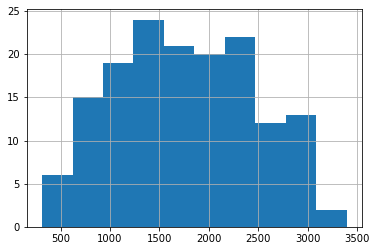

In [221]:
races_final.entrants_count_avg.hist()

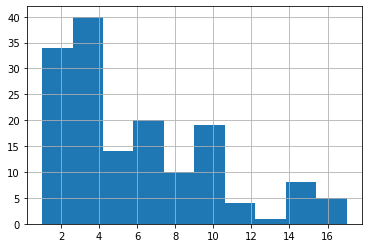

In [222]:
races_final.n_years_existance.hist()

## Add Country code (Query OpenCageData API)

In [223]:
queryCodes = False

if queryCodes:
    races_geo_info = {}
    import requests
    from config import Cfg
    apiKey = Cfg.opencage_api_key
    for race in races_final.race.values:
        lat,lon = races_final.loc[races_final.race == race, ['lat', 'lon']].values[0]
        requestString = f"https://api.opencagedata.com/geocode/v1/json?q={lat},{lon}&key={Cfg.opencage_api_key}"
        r = requests.get(requestString)
        races_geo_info[race] = r.json()['results'][0]
    
    with open("./../data/geo-data/races_geo_info.json", 'w') as f:
        f.write(json.dumps(races_geo_info))
        
else:
    with open("./../data/geo-data/races_geo_info.json", 'r') as f:
        races_geo_info = json.loads(f.read())
        
        
races_final['country_code'] = None
for race in races_final.race.values:
    country_code = races_geo_info[race]
    races_final.loc[races_final.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

## Does race have a ironKids race ?

Try to get the race by crossing websites information with the race list

In [224]:
ironKids_races = {}
with open("./../data/races/ironKids-races.json") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        ironKids_races[data['name'].strip().replace("IRONKIDS ", "")] = data
        
all_races = {}
with open("./../data/races/races.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        all_races[data['website'].split('.asp')[0]] = data
  
not_matched = []
for kidsrace in ironKids_races:
    # try to find a match in all_races dataset
    url = ironKids_races[kidsrace]['url']
    match = 0
    duplicate = 0
    for race in all_races:
        if re.match(race, url):
            # try first to match parent website
            ironKids_races[kidsrace]['race_parent'] = all_races[race]['id']
            match = 1
            
        if not match:
            # there is a bunch of Fun Run in races title, try to match name without
            stripped_name = kidsrace.replace(" Fun Run", "")
            if stripped_name in all_races[race]['name']:
                ironKids_races[kidsrace]['race_parent'] = all_races[race]['id']
                match = 1
                # get my attention if we match several races
                duplicate+=1
                if duplicate>1:
                    print("---- duplicate ----", duplicate, kidsrace)     
            
    if not match:
        not_matched.append(kidsrace)
        print(kidsrace, "-->", ironKids_races[kidsrace]['url'])

Cambridge Fun Run --> http://www.ironman.com/triathlon/events/americas/ironkids/eagleman.aspx
Warsaw --> http://www.ironman.com/triathlon/events/emea/ironkids/ironkids-warsaw.aspx
Les Sables dOlonne --> http://www.ironman.com/triathlon/events/emea/ironman-70.3/les-sables-dolonne/athletes/ironkids.aspx
Haugesund Norway --> http://www.ironman.com/triathlon/events/emea/ironkids/ironkids-norway.aspx
Coeur d Alene Fun Run --> http://www.ironman.com/triathlon/events/americas/ironkids/coeur-d-alene.aspx
Westfriesland --> http://www.ironman.com/triathlon/events/emea/multisport/multisport-westfriesland/side-events/ironkids.aspx
Vitoria-Gasteiz --> http://www.ironman.com/triathlon/events/emea/ironman/vitoria-gasteiz/side-events/ironkids.aspx
Dip 'N' Dash Lake Placid --> http://www.ironman.com/triathlon/events/americas/ironkids/lake-placid-dip-n-dash.aspx
Subaru Canada Fun Run --> http://www.ironman.com/triathlon/events/americas/ironkids/canada.aspx
Lake Placid 70.3 Fun Run --> http://www.ironman

In [225]:
# manually match the ones left
manual_matches = {
    "Cambridge Fun Run": "eagleman70.3",
    "Warsaw": None, # new race
    "Les Sables dOlonne": None, # new race
    "Haugesund Norway": "haugesund",
    "Coeur d Alene Fun Run": "coeurdalene70.3",
    "Westfriesland": None, # irrelevant, own festival
    "Vitoria-Gasteiz": None, # new race
    "Dip 'N' Dash Lake Placid": None, # irrelevant, own festival
    "Subaru Canada Fun Run": "canada", 
#     "Sonoma County Builders Santa Rosa Fun Run": "santarosa70.3",
    "Lake Placid 70.3 Fun Run": "lakeplacid70.3",
    "Superfrog Fun Run": "superfrog70.3",
    "Alpharetta": None, # new race
    "Keiki Dip 'n Dash": None, # new race
    "Mar del Plata": None, # new race
    "Clearwater Fun Run": None, # other festival 
    "Galveston Fun Run": None, # new race and will be for Texas 70.3 commemorative year
    "Dip 'N' Dash Florida": "florida70.3"
}

for kidsrace in manual_matches:
    ironKids_races[kidsrace]['race_parent'] = manual_matches[kidsrace]
    

In [226]:
# make sure we covered everything
for kidsrace in ironKids_races:
    if ironKids_races[kidsrace].get('race_parent', 10) == 10:
        print(ironKids_races)
        
races_parent = []
for kidsrace in ironKids_races:
    prace = ironKids_races[kidsrace]['race_parent']
    if prace: # some are set to None
        races_parent.append(prace)

races_final['ironkids_race'] = 0
for race in races_parent:
    if races_final.race.str.contains(f"{race}$").sum() > 0:
        races_final.loc[races_final.race == race, 'ironkids_race'] = 1
#         races_final.loc[races_final.race.str.contains(f"{race}$"), 'ironkids_race'] = 1
    else:
        print(race)
        
races_final.head()

uk70.3
maastricht
aarhus70.3


,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,run_distance,run_elevationGain,run_score,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race
5,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,20880.8,219.2,1.3,2.783388,89332.1,506.7,0.8,1949.4,ocean,0
6,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,41597.4,178.5,0.9,3.839884,178983.9,500.3,0.7,3767.4,lake,1
7,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,20812.2,101.4,0.4,8.599225,87609.5,505.0,1.2,2010.0,river,0
8,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,20643.3,81.3,0.5,3.520386,89303.6,249.7,0.3,1903.7,river,1
9,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,20883.8,88.9,0.5,3.816421,89840.0,293.7,0.6,1928.4,harbor,1


## Race attractivity

Do athletes who have the possibility of coming back to the race actually returns?

In [227]:
# need results data for that
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [228]:
# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(races_final['race'])]

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])
df_results['year'] = df_results['year'].apply(int)

# keep only results from before 2019 since year is running currently
df_results = df_results.loc[df_results['year'] < 2019]

# add years in sport
years_in_sport = (df_results
     .groupby('athlete')
     .pipe(lambda g: ((g.date.max()-g.date.min()).astype('timedelta64[Y]'))+1) # add 1 so if only one race will be 1 year
     .rename('years_in_sport') 
)

df_results = df_results.merge(years_in_sport, left_on="athlete", right_on="athlete", how="left")
df_results['years_in_sport'] = df_results.years_in_sport.astype(int)

len(df_results)

1677097

In [229]:
# keep only athletes that have done more than one season
# so they had the ability to redo the same race if they wanted
df_multi_season = df_results.loc[df_results["years_in_sport"]>1]

# number of editions of the race
n_editions = (df_multi_season 
        .groupby(['race', 'year'])
        .size()
        .reset_index()
        .groupby('race')
        .size()
        .rename("n_edition")
)

# how many times races have been raced by those multi-season athletes?
total_hits  = (
    df_multi_season 
        .groupby(['race'])
        .size()
        .reset_index()
        .rename(columns={0: "total_hits"})
)

# how many times multi-season athletes returned to race again the same race?
returned_hits = (
    df_multi_season 
        .groupby(['race', 'athlete'])
        .size()
        .reset_index()
        .groupby('race')
        .size()
        .rename("returned_hits")
)


results = (
    total_hits
        .merge(returned_hits, left_on="race", right_on="race", how="left")
        .merge(n_editions, left_on="race", right_on="race", how="left")
)
results["ratio"] = results['returned_hits']/results['total_hits']
results.head()

,race,total_hits,returned_hits,n_edition,ratio
0,Arizona70.3,5064,4032,4,0.796209
1,DunLaoghaire70.3,800,789,1,0.986250
2,Florianopolis70.3,609,608,1,0.998358
3,Haugesund70.3,2406,1516,4,0.630091
4,IMsubicbay,1036,1034,1,0.998069


Only the races with more than 1 editions have potential returning entrants. If returned hits is < than total_hits it means there are entrants with same name

In [230]:
len(results.loc[results.n_edition > 1])

138

Weighted ratio:

$$WR=(\frac{v}{v+m}*R) + (\frac{m}{v+m}*C)$$

where:
- $v$ is the number of valid competitors (at least 2 years of experience in the sport) who entered the race
- $m$ is the minimum number of competitors required to be listed in the chart
- $R$ is the ratio of returning competitors from the valid competitor pool
- $C$ is the mean returning ratio across the whole report

In [231]:
races_attractivity_score = results.copy()
# keep only races with >1 editions
races_attractivity_score = races_attractivity_score.loc[races_attractivity_score.n_edition>1]

c = races_attractivity_score.ratio.mean()

m = races_attractivity_score["total_hits"].quantile(0.6)


# Function that computes the weighted ratio of each race
def weighted_ratio(df, m=m, C=c):
    v = df['total_hits']
    R = df['ratio']
    # Calculation based on the IMDB formula
    return ((v/(v+m) * R) + (m/(m+v) * C))

races_attractivity_score["attractivity_score"] = races_attractivity_score.apply(weighted_ratio, axis=1)

In [232]:
races_attractivity_score.sort_values('attractivity_score', ascending=False).head()

,race,total_hits,returned_hits,n_edition,ratio,attractivity_score
17,barcelona,10600,9034,5,0.852264,0.796820
51,emiliaromagna,4023,3766,2,0.936117,0.794627
38,chattanooga,11356,9511,5,0.837531,0.790483
75,lakeplacid70.3,3786,3510,2,0.927100,0.789088
142,vichy,4463,4007,4,0.897827,0.786203


In [233]:
# add back the races with just 1 edition and fill na
race_attractivity = pd.concat([races_attractivity_score, results.loc[results.n_edition == 1]], sort=False).fillna(races_attractivity_score.median())
race_attractivity.head()

,race,total_hits,returned_hits,n_edition,ratio,attractivity_score
0,Arizona70.3,5064,4032,4,0.796209,0.753045
3,Haugesund70.3,2406,1516,4,0.630091,0.705584
5,Maastricht,2926,2647,3,0.904648,0.772855
7,Vietnam70.3,2895,2275,4,0.785838,0.742129
8,alagoas70.3,1050,896,2,0.853333,0.741099


In [234]:
races_final = races_final.merge(race_attractivity[['race', 'attractivity_score']], left_on="race", right_on="race", how="left")
races_final.head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,run_elevationGain,run_score,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score
0,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,219.2,1.3,2.783388,89332.1,506.7,0.8,1949.4,ocean,0,0.741099
1,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,178.5,0.9,3.839884,178983.9,500.3,0.7,3767.4,lake,1,0.688499
2,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,101.4,0.4,8.599225,87609.5,505.0,1.2,2010.0,river,0,0.753045
3,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,81.3,0.5,3.520386,89303.6,249.7,0.3,1903.7,river,1,0.728331
4,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,88.9,0.5,3.816421,89840.0,293.7,0.6,1928.4,harbor,1,0.733810


In [235]:
len(races_final)

159

## Percentage of people from country of the race

In [236]:
nationalities = (df_results
    .groupby(['race', 'country'])
    .size()
    .reset_index()
    .rename(columns={0: 'count'})
    .pivot(index='race', columns='country', values='count')

)

from_country = pd.DataFrame(list(nationalities.index.map(lambda race: {'index': race, 'from_country': nationalities.loc[race, races_final.loc[races_final.race == race, 'country_code'].values[0]]})))
from_country = from_country.set_index('index')

from_country = pd.concat([nationalities.sum(axis=1).rename("total"), from_country], axis=1)

from_country['perc_entrants_from_country'] = from_country['from_country']/from_country['total']
from_country['race'] = from_country.index
from_country.head()

,total,from_country,perc_entrants_from_country,race
Arizona70.3,6952.0,6161.0,0.886220,Arizona70.3
DunLaoghaire70.3,1663.0,1164.0,0.699940,DunLaoghaire70.3
Florianopolis70.3,1224.0,1147.0,0.937092,Florianopolis70.3
Haugesund70.3,4591.0,3625.0,0.789588,Haugesund70.3
IMsubicbay,1247.0,810.0,0.649559,IMsubicbay


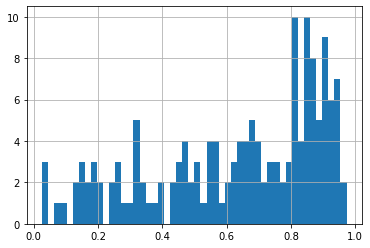

In [237]:
from_country['perc_entrants_from_country'].hist(bins=50)

In [238]:
races_final = races_final.merge(from_country[['race', 'perc_entrants_from_country']], left_on="race", right_on="race", how="left")
races_final.head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,run_score,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score,perc_entrants_from_country
0,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,1.3,2.783388,89332.1,506.7,0.8,1949.4,ocean,0,0.741099,0.917230
1,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,0.9,3.839884,178983.9,500.3,0.7,3767.4,lake,1,0.688499,0.875846
2,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,0.4,8.599225,87609.5,505.0,1.2,2010.0,river,0,0.753045,0.886220
3,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,0.5,3.520386,89303.6,249.7,0.3,1903.7,river,1,0.728331,0.499079
4,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,0.5,3.816421,89840.0,293.7,0.6,1928.4,harbor,1,0.733810,0.908000


In [239]:
# races_final.sort_values('perc_entrants_from_country', ascending=False)

## Demographics (gender balance)

In [240]:
df_results['gender'] = None
df_results.loc[df_results.division.str.contains('M'), 'gender'] = 'M'
df_results.loc[df_results.division.str.contains('F'), 'gender'] = 'F'
df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,bib,country,date,fulldata,score,swim_score,run_score,bike_score,years_in_sport,gender
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,167,USA,2016-11-13,0,98.4,100.0,86.1,100.0,16,M
1,1518208,Josh Amberger,MPRO,1,1,1,1569,209,7416,142,...,4,AUS,2016-11-13,0,99.7,100.0,97.7,100.0,8,M
2,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,1779,JPN,2016-11-13,0,97.1,77.2,100.0,90.7,15,M
3,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,133,AUS,2016-11-13,0,99.9,100.0,100.0,99.7,12,M
4,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,1780,JPN,2016-11-13,0,100.0,100.0,100.0,100.0,13,M


In [241]:
gender_balance = {}
for race in df_results.race.unique():
    gender_balance[race] = {}
    balance = pd.DataFrame(df_results.loc[df_results.race == race]
         .groupby(['year', 'gender'])
         .size()
         .reset_index()
         .rename(columns={0: 'count'})
         .pivot(index='year', columns='gender', values='count')
    )
    balance['total'] = balance.F + balance.M
    balance['ratio_F'] = balance.F/balance.total
    gender_balance[race]['data'] = balance.to_dict(orient='records')
    gender_balance[race]['avg_F'] = balance.ratio_F.mean()

In [242]:
gender_balance_df = pd.DataFrame([
    { 'race': race, 
      'perc_female': gender_balance[race]['avg_F'],
      'n_years': len(gender_balance[race]['data']),
      'avg_total': pd.DataFrame(gender_balance[race]['data']).mean()['total'],
      'type': '70.3' if '70.3' in race else 'full'
    } for race in gender_balance
])
gender_balance_df.head()

,avg_total,n_years,perc_female,race,type
0,1340.000000,3,0.148556,xiamen70.3,70.3
1,856.285714,7,0.131822,malaysia,full
2,1297.750000,4,0.148089,riodejaneiro70.3,70.3
3,2712.647059,17,0.235807,florida,full
4,2371.214286,14,0.079387,france,full


In [243]:
races_final = races_final.merge(gender_balance_df[['race', 'perc_female']], left_on="race", right_on="race", how="left")
races_final.head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,bike_sinusoity,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score,perc_entrants_from_country,perc_female
0,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,2.783388,89332.1,506.7,0.8,1949.4,ocean,0,0.741099,0.917230,0.176758
1,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,3.839884,178983.9,500.3,0.7,3767.4,lake,1,0.688499,0.875846,0.255550
2,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,8.599225,87609.5,505.0,1.2,2010.0,river,0,0.753045,0.886220,0.361263
3,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,3.520386,89303.6,249.7,0.3,1903.7,river,1,0.728331,0.499079,0.117864
4,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,3.816421,89840.0,293.7,0.6,1928.4,harbor,1,0.733810,0.908000,0.367607


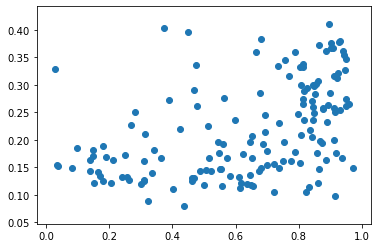

In [244]:
plt.scatter(races_final.perc_entrants_from_country, races_final.perc_female)

## World Championship qualifyiers

In [245]:
qualifyiers = pd.read_csv("./../data/races/qualifyiers-slots.csv")
qualifyiers.head()

,AG Slots,Avg.,Competition,Date,Date,First,Last,Location,Slots
0,2.0,04:01:52,Ironman 70.3 Xiamen,NaN,11/18/2018,04:01:36,04:02:08,NaN,30.0
1,1.0,04:12:02,Ironman 70.3 Liuzhou,NaN,04/14/2019,04:12:02,04:12:02,NaN,25.0
2,1.0,04:14:34,Ironman 70.3 Hawaii,NaN,06/01/2019,04:14:34,04:14:34,NaN,30.0
3,1.0,08:22:23,Ironman Louisville,NaN,10/14/2018,08:22:23,08:22:23,NaN,40.0
4,2.0,08:24:44,Ironman Chattanooga,NaN,09/30/2018,08:16:00,08:33:28,NaN,40.0


In [246]:
races_final["wc_slots"] = 0

for race,slots in qualifyiers.loc[:, ["Competition", "Slots"]].values:
    racename = race.split("Ironman ")[1].lower()
        
    isHalf = False
    match = []
    if "70.3" in race:
        isHalf = True
        racename = racename.replace("70.3 ", "")
    racename = racename.replace("-", "").replace(" ", "")
    candidates = races_final.loc[races_final.race.str.contains(f"^{racename}", regex=True)==True, 'race'].values
    if isHalf:
        for c in candidates:
            if "70.3" in c:
                match.append(c)
    else:
        for c in candidates:
            if "70.3" not in c:
                match.append(c)
                
    if len(match)>0:
        races_final.loc[races_final.race == match[0], 'wc_slots'] = slots
#         print(races_final.loc[races_final.race == match[0], 'wc_slots'])
#     print(racename, match)

races_final.head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score,perc_entrants_from_country,perc_female,wc_slots
0,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,89332.1,506.7,0.8,1949.4,ocean,0,0.741099,0.917230,0.176758,0.0
1,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,178983.9,500.3,0.7,3767.4,lake,1,0.688499,0.875846,0.255550,40.0
2,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,87609.5,505.0,1.2,2010.0,river,0,0.753045,0.886220,0.361263,0.0
3,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,89303.6,249.7,0.3,1903.7,river,1,0.728331,0.499079,0.117864,0.0
4,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,89840.0,293.7,0.6,1928.4,harbor,1,0.733810,0.908000,0.367607,0.0


# Add geo features from other API

## Distance to nearest coastline

In [247]:
# coastline data
shorelines = pd.read_csv('./../data/geo-data/shorelines_lat_lon.csv')
shorelines.head()

#HAVERSINE FUNCTION
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    lon1_rad = np.radians(lon1)
    lon2_rad = np.radians(lon2)
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    a = np.sqrt((np.sin(delta_lat/2))**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * (np.sin(delta_lon/2))**2 )
    d = 2 * 6371000 * np.arcsin(a)
    return d

def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# from sklearn.neighbors import DistanceMetric
# dist = DistanceMetric.get_metric('haversine')



In [248]:
races_final['distance_to_nearest_shoreline'] = 0

for race in races_final.race:
    lat,lon = races_final.loc[races_final.race == race, ['lat', 'lon']].values[0]
    races_final.loc[races_final.race == race, 'distance_to_nearest_shoreline'] = np.min(
        haversine(shorelines.lat, shorelines.lon, lat, lon)/1000 # in km
    )

In [249]:
races_final.sort_values(by="distance_to_nearest_shoreline").head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,bike_elevationGain,bike_score,swim_distance,swim_type,ironkids_race,attractivity_score,perc_entrants_from_country,perc_female,wc_slots,distance_to_nearest_shoreline
101,Nice70.3,IRONMAN 70.3 Nice,2019-09-07,http://www.ironman.com/triathlon/events/emea/i...,"Nice, France",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/Nice70.3/d8689b3984505fb00b63e...,FRA,...,1461.0,4.1,2094.0,ocean,0,0.728331,0.582194,0.133727,0.0,0.029552
53,france,IRONMAN France,2019-06-30,http://www.ironman.com/triathlon/events/emea/i...,"Nice, France",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/france/8b7d5ce18fbc92834813c8a...,FRA,...,3166.9,4.9,3885.2,ocean,1,0.716845,0.435371,0.079387,40.0,0.047496
37,CostaNavarino70.3,"IRONMAN 70.3 Greece, Costa Navarino",2020-04-05,http://www.ironman.com/triathlon/events/emea/i...,Greece,https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/CostaNavarino70.3/308e3b0315d4...,GRC,...,1352.0,3.6,1504.0,ocean,0,NaN,NaN,NaN,0.0,0.292885
14,bintan70.3,IRONMAN 70.3 Bintan,2019-08-25,http://www.ironman.com/triathlon/events/asiapa...,"Bintan, Indonesia",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Asia,races_images_v9/bintan70.3/0124ec78fe4a9012159...,IDN,...,802.7,1.7,2011.9,ocean,0,0.730825,0.137942,0.144399,0.0,0.402116
42,DunLaoghaire70.3,IRONMAN 70.3 Dun Laoghaire,2019-08-25,http://www.ironman.com/triathlon/events/emea/i...,"Dun Laoghaire, Co. Dublin, Ireland",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/DunLaoghaire70.3/4dc09791f0571...,IRL,...,1390.0,4.3,1910.1,ocean,0,0.728331,0.699940,0.179796,0.0,0.441513


## Distance to nearest airport

In [250]:
# open flights dataset
columns_airport = [
    "id",
    "name",
    "city",
    "country",
    "iata",
    "icao",
    "lat",
    "lon",
    "altitude",
    "timezone",
    "dst",
    "tz",
    "type",
    "source"
]

airports_df = pd.read_csv('./../data/geo-data/openflights/airports.dat', names=columns_airport)
aiports_select = airports_df.loc[airports_df.name.str.lower().str.contains("international")]
print(len(airports_df), len(aiports_select))

7698 899


In [251]:
# global aiport database dataset
import sqlite3
conn = sqlite3.connect("./../data/geo-data/global_airport_db/global_airports_sqlite.db")
airports_df2 = pd.read_sql_query("select * from airports;", conn)
conn.close()

len(airports_df2)
# airports_df2[airports_df2.lat_decimal != 0]

9300

In [252]:
races_final['distance_to_nearest_airport'] = 0
races_final['distance_to_nearest_airport_international'] = 0

for race in races_final.race:
    lat,lon = races_final.loc[races_final.race == race, ['lat', 'lon']].values[0]
    races_final.loc[races_final.race == race, 'distance_to_nearest_airport'] = np.min(
        haversine(airports_df.lat, airports_df.lon, lat, lon)/1000 # in km
    )
    races_final.loc[races_final.race == race, 'distance_to_nearest_airport_international'] = np.min(
        haversine(aiports_select.lat, aiports_select.lon, lat, lon)/1000 # in km
    )

In [253]:
races_final.sort_values(by="distance_to_nearest_airport_international", ascending=False).head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,swim_distance,swim_type,ironkids_race,attractivity_score,perc_entrants_from_country,perc_female,wc_slots,distance_to_nearest_shoreline,distance_to_nearest_airport,distance_to_nearest_airport_international
13,bariloche70.3,IRONMAN 70.3 Bariloche,2020-03-01,http://www.ironman.com/triathlon/events/americ...,"Bariloche, Argentina",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/bariloche70.3/be2c6b01aee3bba6...,ARG,...,2258.9,lake,1,0.728331,0.652619,0.167369,0.0,87.181853,13.258191,861.846981
76,lanzarote,IRONMAN Lanzarote,2020-05-23,http://www.ironman.com/triathlon/events/emea/i...,"Canarias, Spain",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/lanzarote/a454af43bd698223b7e3...,ESP,...,3996.4,ocean,1,0.713254,0.321505,0.088769,40.0,0.792303,2.800409,757.094153
77,lanzarote70.3,IRONMAN 70.3 Lanzarote,2019-10-05,http://www.ironman.com/triathlon/events/emea/i...,"Lanzarote, Canary Islands, Spain",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/lanzarote70.3/eb9dea181fe8d449...,ESP,...,1841.9,harbor,0,0.750648,0.189816,0.168657,0.0,0.665686,19.111909,746.076662
60,haugesund,IRONMAN Haugesund,2019-06-30,http://www.ironman.com/triathlon/events/emea/i...,"Haugesund, Norway",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/haugesund/f7b282654693d66ab1c9...,NOR,...,3907.1,lake,1,0.728331,0.486280,0.143293,30.0,3.041109,7.717471,697.904653
61,Haugesund70.3,IRONMAN 70.3 Haugesund,2019-06-30,http://www.ironman.com/triathlon/events/emea/i...,"Haugesund, Norway",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Europe,races_images_v9/Haugesund70.3/f7b282654693d66a...,NOR,...,2077.3,lake,0,0.705584,0.789588,0.177777,0.0,3.076990,7.680291,697.866076


## "Touristicity" of a race

In [254]:
races_final['n_metropolitan_cities'] = 0
races_final['n_hotels'] = 0
races_final['n_restaurants'] = 0
races_final['n_entertainment'] = 0
races_final['n_nightlife'] = 0
races_final['n_shops'] = 0
races_final['n_bike_shops'] = 0
races_final['n_pools'] = 0
races_final['n_athletic_centers'] = 0
races_final['n_fitness_centers'] = 0

distance = 100


# metropolitan area
with open("./../data/geo-data/races-metropolitan-area.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_metropolitan_cities'] = data[race]['totalCount']
    
# hotels
with open(f"./../data/geo-data/races-poi-hotels-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_hotels'] = data[race]['poi_n_results']
    
# restaurants
with open(f"./../data/geo-data/races-poi-food-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_restaurants'] = data[race]['poi_n_results']
    
# entertainment
with open(f"./../data/geo-data/races-poi-entertainment-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_entertainment'] = data[race]['poi_n_results']
    
# nightlife
with open(f"./../data/geo-data/races-poi-nightlife-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_nightlife'] = data[race]['poi_n_results']
    
# shops
with open(f"./../data/geo-data/races-poi-shops_services-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_shops'] = data[race]['poi_n_results']

# bike shops
with open(f"./../data/geo-data/races-poi-shops_bike-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_bike_shops'] = data[race]['poi_n_results']

# pools
with open(f"./../data/geo-data/races-poi-pool-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_pools'] = data[race]['poi_n_results']

# athletic centers
with open(f"./../data/geo-data/races-poi-athletic_centers-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_athletic_centers'] = data[race]['poi_n_results']

# fitness centers
with open(f"./../data/geo-data/races-poi-fitness_centers-{distance}km.json") as f:
    data = json.loads(f.read())
for race in data:
    races_final.loc[races_final.race == race, 'n_fitness_centers'] = data[race]['poi_n_results']
    
races_final.head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,n_metropolitan_cities,n_hotels,n_restaurants,n_entertainment,n_nightlife,n_shops,n_bike_shops,n_pools,n_athletic_centers,n_fitness_centers
0,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,1,182,227,60,73,196,17,19,137,134
1,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,5,283,239,210,245,249,177,211,243,246
2,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,5,283,239,210,245,249,177,210,243,246
3,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,1,76,58,26,39,124,6,9,52,40
4,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,23,238,244,179,248,138,110,125,134,144


In [255]:
races_final.columns

Index(['race', 'racename', 'date', 'imlink', 'city', 'image_url', 'logo_url',
       'region', 'images', 'country_code', 'lat', 'lon', 'n_years_existance',
       'entrants_count_avg', 'run_sinusoity', 'run_distance',
       'run_elevationGain', 'run_score', 'bike_sinusoity', 'bike_distance',
       'bike_elevationGain', 'bike_score', 'swim_distance', 'swim_type',
       'ironkids_race', 'attractivity_score', 'perc_entrants_from_country',
       'perc_female', 'wc_slots', 'distance_to_nearest_shoreline',
       'distance_to_nearest_airport',
       'distance_to_nearest_airport_international', 'n_metropolitan_cities',
       'n_hotels', 'n_restaurants', 'n_entertainment', 'n_nightlife',
       'n_shops', 'n_bike_shops', 'n_pools', 'n_athletic_centers',
       'n_fitness_centers'],
      dtype='object')

## Weather info

In [256]:
with open('./../data/geo-data/races_weather.json', 'r') as f:
    weather_data = json.loads(f.read())

In [257]:
weather_data_filtered = []

nope = 0
for race in weather_data:
    race_weather_data = weather_data[race]['editions']
    for r in race_weather_data:
        if r['weather'].get('daily', False):
            extract = {
                'race': r['id'],
                'year': r['date'].split('-')[0],
                'temperatureMin': r['weather']['daily']['data'][0]['temperatureMin'],
                'temperatureMax': r['weather']['daily']['data'][0]['temperatureMax'],
                'apparentTemperatureMin': r['weather']['daily']['data'][0]['apparentTemperatureMin'],
                'apparentTemperatureMax': r['weather']['daily']['data'][0]['apparentTemperatureMax']
            }
            weather_data_filtered.append(extract)
        else:
            if r['weather'].get('hourly'):
                temperature = [ t['temperature'] for t in  r['weather']['hourly']['data']] 
                apparentTemperature = [ t['apparentTemperature'] for t in  r['weather']['hourly']['data']]
                extract = {
                    'race': r['id'],
                    'year': r['date'].split('-')[0],
                    'temperatureMin': np.min(temperature),
                    'temperatureMax': np.max(temperature),
                    'apparentTemperatureMin': np.min(apparentTemperature),
                    'apparentTemperatureMax': np.max(apparentTemperature)
                }
                weather_data_filtered.append(extract)
            else:
                nope+=1
        
len(weather_data_filtered)

945

In [258]:
races_final = races_final.merge(
    pd.DataFrame(weather_data_filtered)
        .groupby("race")[['temperatureMin', 'temperatureMax', 'apparentTemperatureMin', 'apparentTemperatureMax']]
        .mean()
        .reset_index(),
    left_on="race", right_on="race", how="left"
)
races_final.head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,n_nightlife,n_shops,n_bike_shops,n_pools,n_athletic_centers,n_fitness_centers,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
0,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,73,196,17,19,137,134,68.025000,82.035000,68.785000,85.685000
1,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,245,249,177,211,243,246,54.022143,76.367143,54.022143,76.367143
2,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,245,249,177,210,243,246,66.832500,90.332500,66.840000,90.332500
3,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,39,124,6,9,52,40,51.890000,71.710000,51.890000,71.710000
4,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,248,138,110,125,134,144,59.420000,71.270000,59.950000,73.276667


## Times info

In [259]:
(df_results.loc[(df_results[['swim', 'bike', 'run']] == -1).sum(axis=1) == 0]
     .groupby(["race", "year"])[['swim', 'bike', 'run']]
     .agg(['min', 'mean', 'max'])
).head(10)

swim                     bike                       \
                         min         mean   max   min          mean    max   
race              year                                                       
Arizona70.3       2015  1539  2839.827462  4793  8220  11140.902439  18258   
                  2016  1519  2658.242263  5942  8192  11172.681698  16269   
                  2017  1528  2708.800485  4175  8053  11255.400646  16510   
                  2018  1454  2568.175842  4180  7936  11134.842235  15379   
DunLaoghaire70.3  2018  1525  2912.620521  4752  8657  13123.228827  19223   
Florianopolis70.3 2018  1364  2180.997124  3955  7384  10253.678811  14572   
Haugesund70.3     2015  1382  2383.900380  4167  7705  10228.034221  16940   
                  2016  1219  2153.961571  3371  7617  10368.360376  15551   
                  2017  1575  2392.159066  4018  8016  10572.785317  15014   
                  2018  1711  2497.211957  3745  7675  10359.320652  16208   

                         run                      
                         min         mean    max  
race              year                            
Arizona70.3       2015  5198  9573.565492  15486  
                  2016  4872  9072.354553  15647  
                  2017  4917  9307.309370  21750  
                  2018  4784  8906.874281  13422  
DunLaoghaire70.3  2018  2988  7534.992671  13135  
Florianopolis70.3 2018  3844  7092.867689  11767  
Haugesund70.3     2015  4155  6986.840304  12358  
                  2016  4288  6948.390265  11502  
                  2017  4535  6894.164627  11534  
                  2018  4605  7157.902174  11474

In [260]:
avg_times = (df_results.loc[(df_results[['swim', 'bike', 'run']] == -1).sum(axis=1) == 0]
     .groupby(["race", "year"])[['swim', 'bike', 'run']]
     .agg(['min', 'mean', 'max'])
     .reset_index()
     .groupby('race')
     .mean()[['swim', 'bike', 'run']]
)
avg_times.columns = ['_'.join(col).strip() for col in avg_times.columns.values]
avg_times = avg_times.reset_index()
avg_times.head()
len(avg_times)

/miniconda3/envs/data-science/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


154

In [261]:
races_final = races_final.merge(avg_times, left_on="race", right_on="race", how="left")
races_final.head()

,race,racename,date,imlink,city,image_url,logo_url,region,images,country_code,...,apparentTemperatureMax,swim_min,swim_mean,swim_max,bike_min,bike_mean,bike_max,run_min,run_mean,run_max
0,alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,...,85.685000,1448.000000,2288.078225,4201.000000,6720.000000,9560.845075,14475.500000,4791.500000,7484.210043,15817.000000
1,arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,...,76.367143,2866.928571,4929.300964,8357.928571,15552.928571,22732.497606,30975.857143,9291.571429,18506.510752,31598.642857
2,Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,...,90.332500,1510.000000,2693.761513,4772.500000,8100.250000,11175.956754,16604.000000,4942.750000,9215.025924,16576.250000
3,astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,...,71.710000,1462.000000,2542.563966,4768.000000,7721.000000,10664.704691,15261.000000,4713.000000,7369.575693,13246.000000
4,atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,...,73.276667,1312.000000,2438.714203,4572.000000,7813.666667,10913.723092,17382.666667,4652.333333,8477.862647,14797.000000


## Percentage of DNF

## is 70.3

In [262]:
races_final['is_70.3'] = races_final.race.apply(lambda x: '70.3' in x)

## SAVE FINAL FILE

In [263]:
races_final.columns

Index(['race', 'racename', 'date', 'imlink', 'city', 'image_url', 'logo_url',
       'region', 'images', 'country_code', 'lat', 'lon', 'n_years_existance',
       'entrants_count_avg', 'run_sinusoity', 'run_distance',
       'run_elevationGain', 'run_score', 'bike_sinusoity', 'bike_distance',
       'bike_elevationGain', 'bike_score', 'swim_distance', 'swim_type',
       'ironkids_race', 'attractivity_score', 'perc_entrants_from_country',
       'perc_female', 'wc_slots', 'distance_to_nearest_shoreline',
       'distance_to_nearest_airport',
       'distance_to_nearest_airport_international', 'n_metropolitan_cities',
       'n_hotels', 'n_restaurants', 'n_entertainment', 'n_nightlife',
       'n_shops', 'n_bike_shops', 'n_pools', 'n_athletic_centers',
       'n_fitness_centers', 'temperatureMin', 'temperatureMax',
       'apparentTemperatureMin', 'apparentTemperatureMax', 'swim_min',
       'swim_mean', 'swim_max', 'bike_min', 'bike_mean', 'bike_max', 'run_min',
       'run_mean', 'run

In [264]:
# save final
races_final.to_csv("./../data/clean/races_info_features.csv", index=False)